<a href="https://colab.research.google.com/github/fockspaces/ML2021spring/blob/main/HW2%20Phoneme%20Classification/FC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

* Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW02/HW02.pdf
* Video (Chinese): https://youtu.be/PdjXnQbu2zo
* Video (English): https://youtu.be/ESRr-VCykBs


## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.

This homework is a multiclass classification task, 
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !cp "/content/drive/MyDrive/timit_11_v2.zip 的副本" "data.zip"
# !unzip data.zip
!ls 

data.zip  modelFC15.ckpt  modelFClow.ckpt     predictionFC20.csv   sample_data
drive	  modelFC20.ckpt  predictionFC15.csv  predictionFClow.csv  timit_11


## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

In [ ]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train.shape))
print('Size of testing data: {}'.format(test.shape))

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


In [ ]:
def sample(data, stride):
  base = data.copy()
  for step in range(1, stride+1, 1):
    Rshift = np.roll(base,step,axis=0)
    data = np.concatenate((Rshift,data), axis=1)
  for step in range(-1, -1-1*stride, -1):
    Lshift = np.roll(base,step,axis=0)
    data = np.concatenate((data,Lshift), axis=1)

  data = np.reshape(data, (-1,2*stride+1,39))
  return data

def normalize(data):
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  return (data - mean)/std

In [ ]:
stride = 10
# (,429)split to(11,39)
train = np.reshape(train, (-1,11,39))
test = np.reshape(test, (-1,11,39))

# pick only the 5th MFCC which is corresponding to label
train = train[:,5,:]
test = test[:,5,:]

# include nearby MFCC (To extend the frame length)
train = sample(train, stride)
test = sample(test, stride)

# flatten to (-1,39*n)
train = np.reshape(train, (-1,(2*stride+1)*39))
test = np.reshape(test, (-1,(2*stride+1)*39))

# normalize data
# train = normalize(train)
# test = normalize(test)

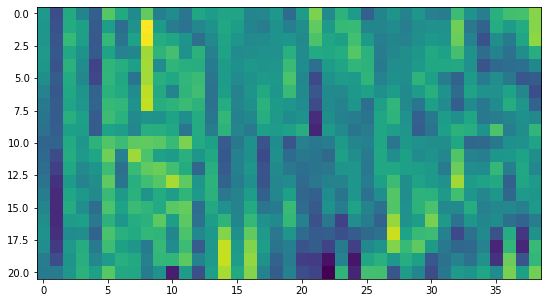

In [ ]:
import matplotlib.pyplot as plt
mfcc = np.reshape(train[0], ((2*stride+1),39))
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(mfcc);

## Create Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [ ]:
VAL_RATIO = 0

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (1229932, 819)
Size of validation set: (0, 819)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [ ]:
BATCH_SIZE = 1024

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [ ]:
import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

2840

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
        #1
        nn.Linear((2*stride+1)*39, 1024),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.ReLU(),
        #2
        nn.Linear(1024, 2048),
        nn.BatchNorm1d(2048),
        nn.Dropout(0.5),
        nn.ReLU(),
        #3
        nn.Linear(2048, 2048),
        nn.BatchNorm1d(2048),
        nn.Dropout(0.5),
        nn.ReLU(),
        #4
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.ReLU(),
        #5
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.ReLU(),
        #6
        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        nn.ReLU(),
        
        #7
        nn.Linear(128, 39)
        )
        

    def forward(self, x):
        x = self.net(x)
        x = F.log_softmax(x, dim=1)
        return x

## Training

In [ ]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fix random seeds for reproducibility.

In [ ]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [ ]:
# fix random seed for reproducibility
same_seeds(0)

# get device 
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 500               # number of training epoch
learning_rate = 1e-4       # learning rate
l2 = 0
# the path where checkpoint saved
model_path = './modelFClow.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)

DEVICE: cuda


In [ ]:
# start training

best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step() 

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


[001/500] Train Acc: 0.379107 Loss: 2.284816
[002/500] Train Acc: 0.514639 Loss: 1.683751
[003/500] Train Acc: 0.560551 Loss: 1.517951
[004/500] Train Acc: 0.586388 Loss: 1.423724
[005/500] Train Acc: 0.603061 Loss: 1.359067
[006/500] Train Acc: 0.615586 Loss: 1.313407
[007/500] Train Acc: 0.625730 Loss: 1.275816
[008/500] Train Acc: 0.633501 Loss: 1.244029
[009/500] Train Acc: 0.640634 Loss: 1.218126
[010/500] Train Acc: 0.646476 Loss: 1.195710
[011/500] Train Acc: 0.652316 Loss: 1.174391
[012/500] Train Acc: 0.657459 Loss: 1.156297
[013/500] Train Acc: 0.661549 Loss: 1.138222
[014/500] Train Acc: 0.665294 Loss: 1.123894
[015/500] Train Acc: 0.669060 Loss: 1.109621
[016/500] Train Acc: 0.671697 Loss: 1.097781
[017/500] Train Acc: 0.675374 Loss: 1.084455
[018/500] Train Acc: 0.677828 Loss: 1.074162
[019/500] Train Acc: 0.680412 Loss: 1.062237
[020/500] Train Acc: 0.683376 Loss: 1.053156
[021/500] Train Acc: 0.685604 Loss: 1.041981
[022/500] Train Acc: 0.687775 Loss: 1.035086
[023/500] 

KeyboardInterrupt: ignored

## Testing

In [ ]:
!cp -r "/content/modelFClow.ckpt" "/content/drive/MyDrive/"

Create a testing dataset, and load model from the saved checkpoint.

In [ ]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

Make prediction.

In [ ]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        for y in test_pred.cpu().numpy():
            predict.append(y)

In [ ]:
count = 0
for i in range(1, len(predict)-1):
    step = 1
    previous_ = predict[i-step]
    next_ = predict[i+step]
    current_ = predict[i]
    if (previous_ != current_) and (next_ != current_) and (previous_ == next_):
        print('idx',i,'correct', current_, 'to', previous_)
        predict[i] = previous_
        count +=1

print('total number of correction %d, correction percent %.2f'% (count, count/len(predict)))

for i in range(1, len(predict)-1):
    step = 2
    if i == 1 or i == len(predict)-2: step = 1
    previous_ = predict[i-step]
    next_ = predict[i+step]
    current_ = predict[i]
    if (previous_ != current_) and (next_ != current_) and (previous_ == next_):
        print('idx',i,'correct', current_, 'to', previous_)
        predict[i] = previous_
        count +=1

print('total number of correction %d, correction percent %.2f'% (count, count/len(predict)))



total number of correction 0, correction percent 0.00
idx 598 correct 3 to 7
idx 673 correct 0 to 1
idx 751 correct 1 to 2
idx 752 correct 1 to 2
idx 1066 correct 38 to 33
idx 1085 correct 4 to 1
idx 1113 correct 9 to 7
idx 1116 correct 7 to 9
idx 1185 correct 34 to 33
idx 1405 correct 17 to 14
idx 1418 correct 4 to 13
idx 1419 correct 4 to 13
idx 1538 correct 18 to 19
idx 1809 correct 21 to 36
idx 1837 correct 34 to 38
idx 1838 correct 34 to 38
idx 1951 correct 12 to 13
idx 2097 correct 7 to 9
idx 2145 correct 35 to 31
idx 2146 correct 35 to 31
idx 2313 correct 14 to 17
idx 2922 correct 2 to 4
idx 3728 correct 4 to 7
idx 3911 correct 9 to 7
idx 3912 correct 9 to 7
idx 4152 correct 33 to 34
idx 4245 correct 7 to 3
idx 4995 correct 2 to 4
idx 5144 correct 17 to 14
idx 5417 correct 12 to 7
idx 5440 correct 38 to 18
idx 5441 correct 38 to 18
idx 5532 correct 38 to 7
idx 5911 correct 9 to 7
idx 6099 correct 38 to 18
idx 6100 correct 18 to 38
idx 6124 correct 14 to 2
idx 6205 correct 18 to 

Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [ ]:
with open('predictionFClow.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))

In [ ]:
# !cp -r "/content/predictionFC15.csv" "/content/drive/MyDrive/"